In [50]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_score, silhouette_samples
#import matplotlib.ticker as ticker
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm
import itertools
import networkx as nx
import plotly.figure_factory as ff
from itertools import combinations
from IPython.display import display
from pacmap import PaCMAP
from scipy.cluster.hierarchy import linkage, fcluster

In [51]:
cancer_type = "Brain"
non_coding_regions = ['acceptor','donor', 'TATA', 'NonTATA']
file_name = "df_log_odd_score_patientwise.tsv"

In [52]:
output_path = "/home/pdutta/Data/Cancer_wiseGDC/New_data/{}/Generated_files/Kmeans_cluster/all_non_coding_region/Categorise_CPTAC-3".format(cancer_type)
# Subfolders within the base path
clinical_df = pd.read_csv("/home/pdutta/Data/Cancer_wiseGDC/New_data/Brain/Clinical_biospecimen/clinical_mapping.tsv", sep= "\t")
clinical_df.set_index('manifest_patient_id', inplace=True)

In [53]:
clinical_df['project_id'].value_counts(dropna=False)

project_id
CPTAC-3      178
TCGA-LGG      23
TCGA-GBM      12
TCGA-DLBC      1
Name: count, dtype: int64

In [54]:
dict_df = {}
for non_coding_region in non_coding_regions:
    print(non_coding_region)
    file_path= '/home/pdutta/Data/Cancer_wiseGDC/New_data/{}/Generated_files/Variant_Analysis/{}/{}'.format(cancer_type, non_coding_region, file_name)
    df = pd.read_csv(file_path, sep='\t')
    df = df.set_index('Patient_Core_ID', drop=True)
    print(df.shape)
    # Merge the dataframes on the index
    merged_df = df.merge(clinical_df[['project_id']], left_index=True, right_index=True, how='left')
    print(merged_df.shape)
    
    # Filter for the specific project IDs
    filtered_df = merged_df[merged_df['project_id'] == 'CPTAC-3']
    # Drop the 'project_id' column to retain only the columns from 'df'
    filtered_df = filtered_df.drop(columns='project_id')
    print(filtered_df.shape)
    #display(filtered_df)
    dict_df[non_coding_region] = filtered_df

acceptor
(216, 3371)
(216, 3372)
(178, 3371)
donor
(216, 2937)
(216, 2938)
(178, 2937)
TATA
(216, 110)
(216, 111)
(178, 110)
NonTATA
(216, 1898)
(216, 1899)
(178, 1898)


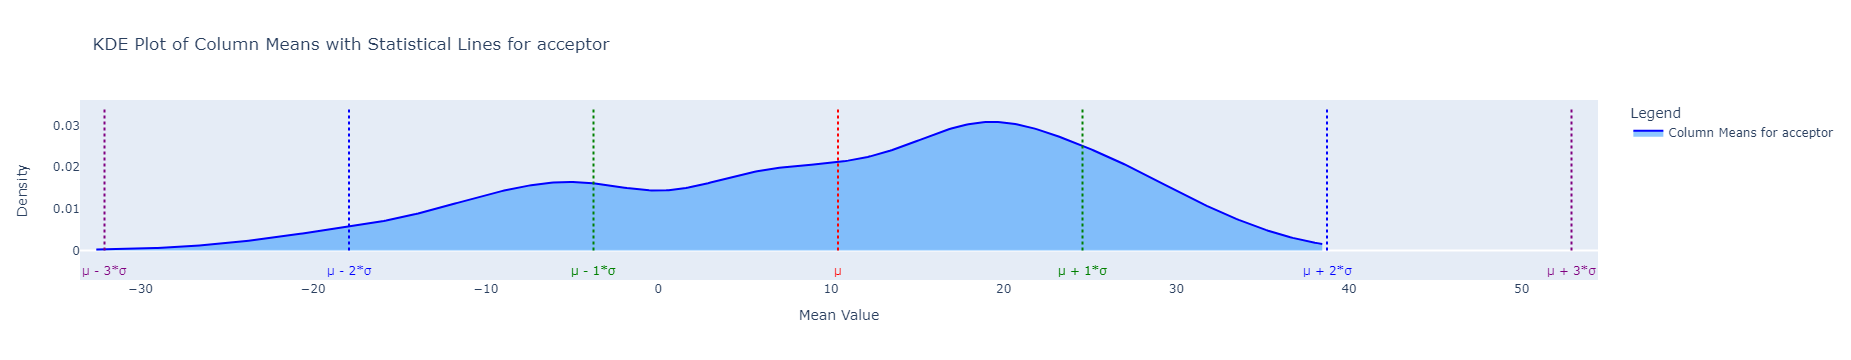

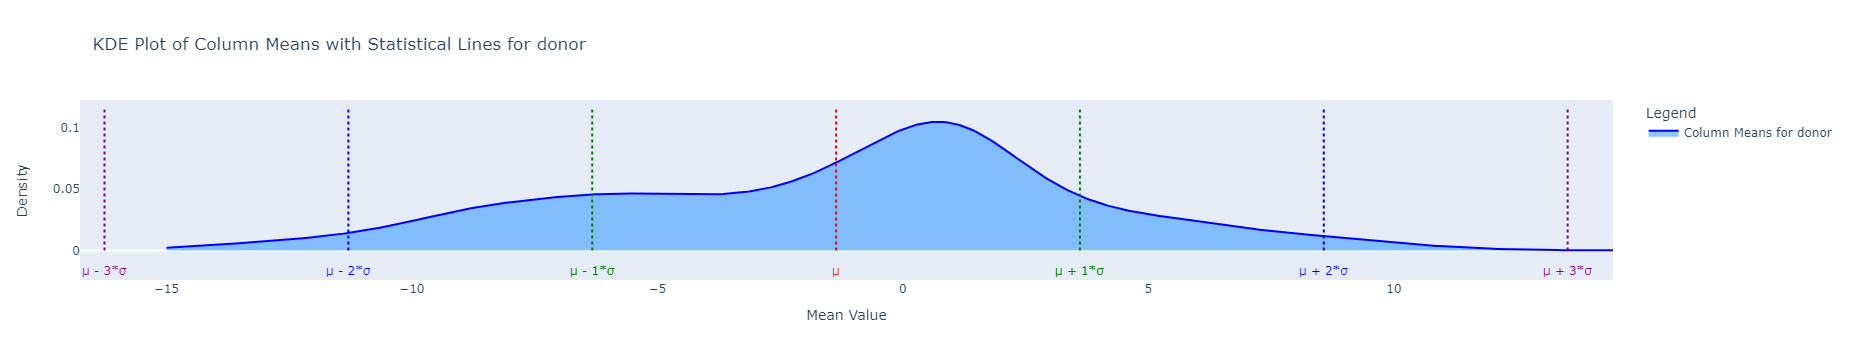

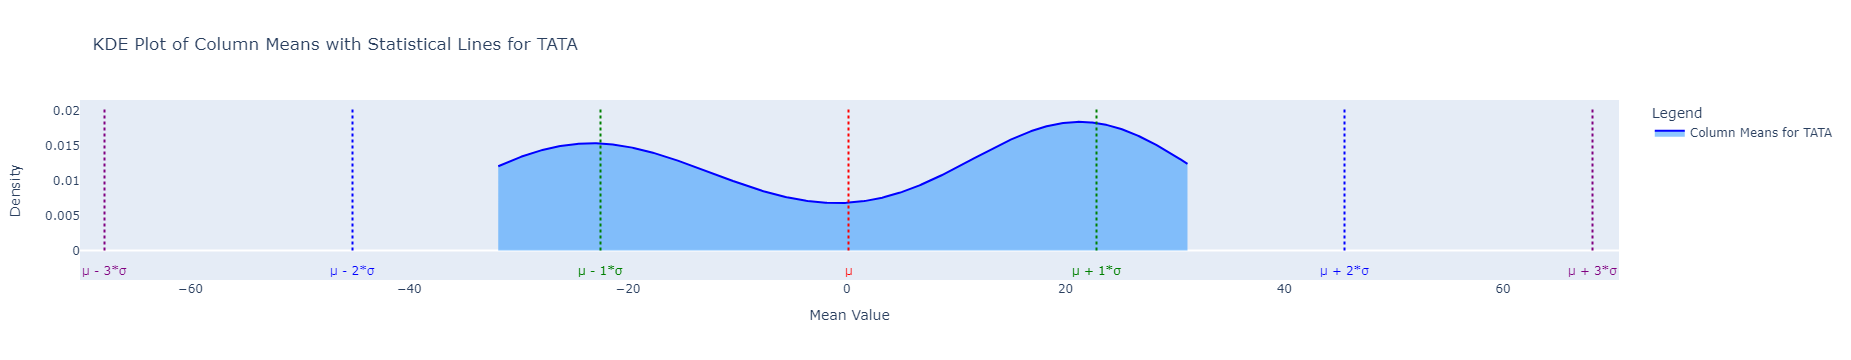

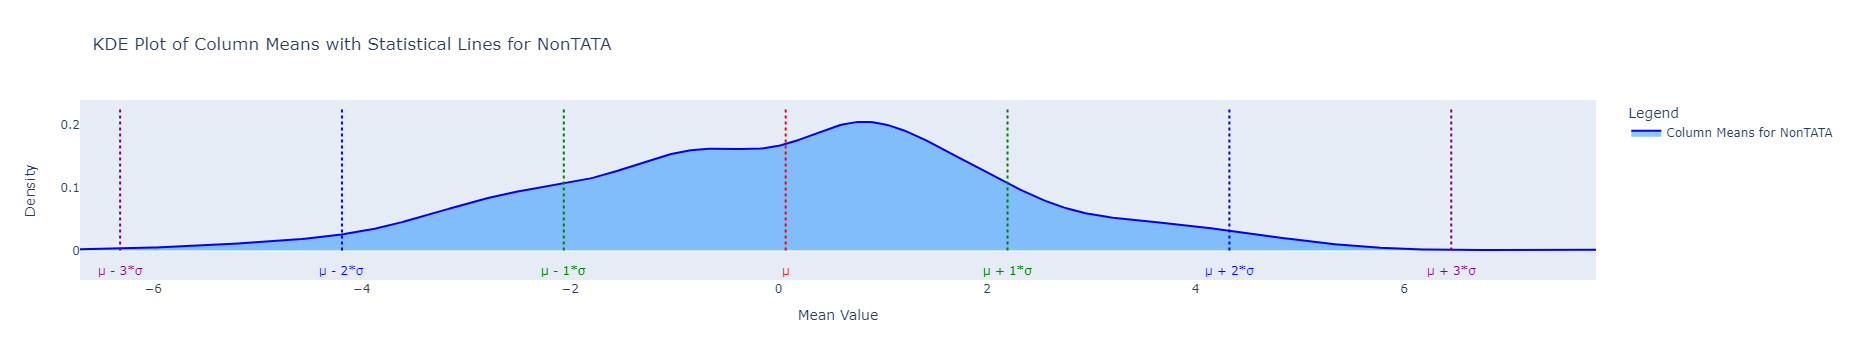

In [55]:
# Assuming dict_df is your dictionary of DataFrames
for key, df in dict_df.items():
    # Calculate the mean for each numeric column, ignoring NaN values
    means = df.select_dtypes(include=[np.number]).mean()

    # Compute overall mean and standard deviation of these means
    overall_mean = means.mean()
    overall_std = means.std()

    # Create a simple KDE plot using Plotly's Figure Factory
    fig = ff.create_distplot([means.dropna()], [f'Column Means for {key}'], show_hist=False, show_rug=False)

    # Add vertical lines for mean and mean ± standard deviations
    lines = [overall_mean, overall_mean - overall_std, overall_mean + overall_std,
             overall_mean - 2 * overall_std, overall_mean + 2 * overall_std,
             overall_mean - 3 * overall_std, overall_mean + 3 * overall_std]
    colors = ['red', 'green', 'green', 'blue', 'blue', 'purple', 'purple']
    names = ['μ', 'μ - 1*σ', 'μ + 1*σ', 'μ - 2*σ', 'μ + 2*σ', 'μ - 3*σ', 'μ + 3*σ']
    line_style = dict(dash='dot', width=2)

    # Update density plot to have a filled color with transparency
    fig.data[0].update(
        marker=dict(color='blue', line=dict(width=0)),
        fill='tozeroy',
        fillcolor='rgba(30,144,255,0.5)'
    )

    # Max density for y-scale of lines
    max_density = fig.data[0].y.max() * 1.1  # Scale it a bit for visual clarity

    # Add dotted vertical lines and x-axis annotations for the statistical measures
    for line, color, name in zip(lines, colors, names):
        fig.add_trace(go.Scatter(
            x=[line, line],
            y=[0, max_density],  # Extend from 0 to max density for visibility
            mode='lines',
            line=dict(color=color, **line_style),
            name=name
        ))

        # Add annotations directly on the x-axis for each line
        fig.add_annotation(
            x=line, y=0,
            text=name,
            showarrow=False,
            yshift=-20,
            xshift=-5 if 'Mean' in name else 0,
            font=dict(color=color)
        )

    # Remove legend for vertical lines
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False) if trace.name in names else (),
    )

    # Update layout for better visualization
    fig.update_layout(
        title=f'KDE Plot of Column Means with Statistical Lines for {key}',
        xaxis_title='Mean Value',
        yaxis_title='Density',
        legend_title='Legend',
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False)
    )

    # Show the plot
    fig.show()

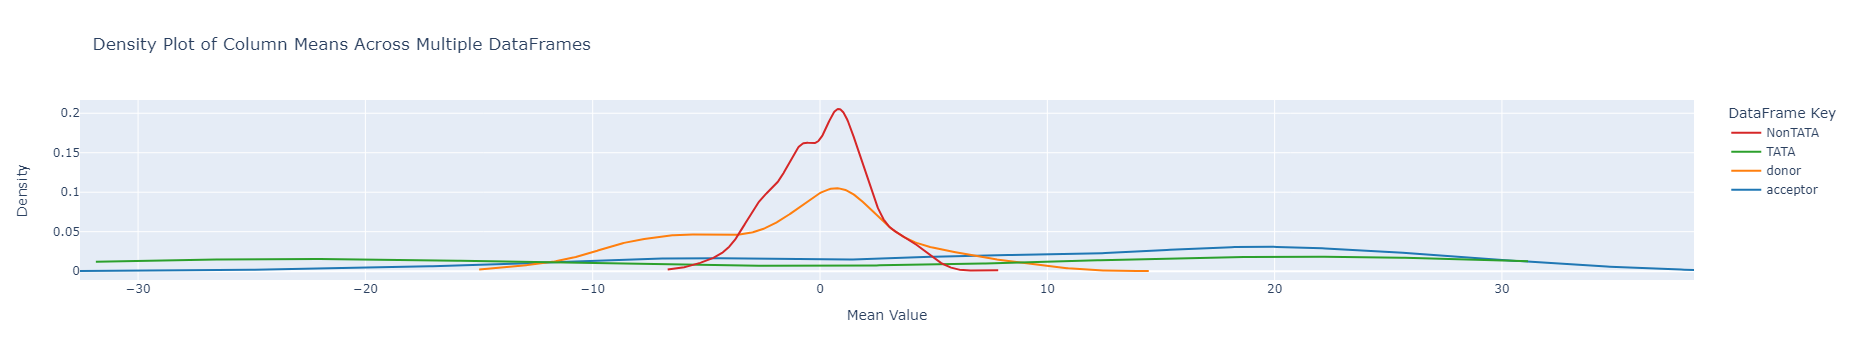

In [56]:
# List to store data for the density plot
data = []
group_labels = []

# Assuming dict_df is your dictionary of DataFrames
for key, df in dict_df.items():
    # Calculate the mean for each numeric column, ignoring NaN values
    means = df.select_dtypes(include=[np.number]).mean()

    # Append the data and labels for the plot
    data.append(means.dropna())
    group_labels.append(key)  # Use the dictionary keys as group labels

# Create the density plot with all means
fig = ff.create_distplot(data, group_labels, show_hist=False, show_rug=False)

# Update layout to add titles and improve legibility
fig.update_layout(
    title='Density Plot of Column Means Across Multiple DataFrames',
    xaxis_title='Mean Value',
    yaxis_title='Density',
    legend_title='DataFrame Key'
)

# Show the plot
fig.show()

In [57]:
# Define a function to categorize based on the overall mean and standard deviation
def categorize_value(x, overall_mean, overall_std):
    if x == 0:
        return 0
    elif x > overall_mean + overall_std:
        return 1
    elif x < overall_mean - overall_std:
        return -1
    else:
        return 0

In [58]:
# Custom function to calculate Mean Absolute Deviation
def calculate_mad(column):
    mean = column.mean()
    return (column - mean).abs().mean()

In [59]:
def silhouette_plot(k, cluster_labels, silhouette_avg, sample_silhouette_values, folder_path, top_n_percent):
    fig = go.Figure()
    y_lower = 10  # Initial lower margin for the silhouette plot
    cluster_info = []  # To store info about clusters for the legend

    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cluster_info.append(f"Cluster {i} [{size_cluster_i} patients]")  # Append cluster info for legend

        fig.add_trace(go.Scatter(
            x=ith_cluster_silhouette_values,
            y=np.arange(y_lower, y_upper),
            mode='lines',
            line=dict(width=0.5),
            fill='tozerox',
            name=f'Cluster {i} [{size_cluster_i} patients]'
        ))

        y_lower = y_upper + 10  # Gap between silhouettes

    # Red dashed line for average silhouette score
    fig.add_trace(go.Scatter(
        x=[silhouette_avg, silhouette_avg],
        y=[0, y_lower],
        mode='lines',
        line=dict(color="red", dash='dash', width=2),
        name='Average silhouette score'
    ))

    # Update plot layout
    fig.update_layout(
        title=f'Silhouette Analysis for k={k} Clusters for top {top_n_percent}% features <br>Average silhouette score {silhouette_avg:.4f}',
        xaxis_title='Silhouette Coefficient Values',
        yaxis_title='Cluster Label',
        yaxis=dict(range=[-0.1, y_lower + 10], showticklabels=False),
        showlegend=True
    )

    # Save and display the figure
    fig.write_html(f"{folder_path}/silhouette_plot_k_{k}_top_feature_{top_n_percent}.html")
    #fig.show()

In [60]:
def kmeans_silhouette_score(scaled_data, n_clusters, result_path, original_indices, top_percentage):
    # Initialize and run KMeans clustering with varying number of clusters
    #display(scaled_data)
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, tol=1e-04, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    # Calculate and return the silhouette score
    score = silhouette_score(scaled_data, labels)
    sample_silhouette_values = silhouette_samples(scaled_data, labels)
    silhouette_plot(k,labels, score, sample_silhouette_values, result_path, top_percentage)
    

    # Create text files for each cluster
    for i in range(n_clusters):
        cluster_file_path = f"{result_path}/cluster_{i}.txt"
        with open(cluster_file_path, 'w') as file:
            indices = original_indices[labels == i]
            for idx in indices:
                file.write(str(idx) + '\n')
    return score

In [61]:
def data_categorized_mad(data):
    # Assuming 'df' is your DataFrame
    # Calculate the mean for each numeric column, ignoring NaN values
    means = data.select_dtypes(include=[np.number]).mean()
    
    # Compute overall mean and standard deviation of these means
    overall_mean = means.mean()
    overall_std = means.std()
    
    # Replace NaN values with 0
    data.fillna(0, inplace=True)
    
    # Apply the categorization function to each element of the dataframe
    for col in data.select_dtypes(include=[np.number]).columns:
        data[col] = data[col].apply(lambda x: categorize_value(x, overall_mean, overall_std))
    #display(data)
    # Calculate MAD for each numeric column
    mad_values = {col: calculate_mad(data[col]) for col in data.select_dtypes(include=[np.number]).columns}

    # Sort columns by MAD in descending order
    mad_sorted = sorted(mad_values.items(), key=lambda x: x[1], reverse=True)
    return (data, mad_values, mad_sorted)

In [62]:
mad_dict = {key: data_categorized_mad(df) for key, df in dict_df.items()}

In [63]:
mad_dict['acceptor'][0]

,chr1_11988386_11988465_11988402_11988403_G_GTT,chr1_16041210_16041289_16041214_16041215_G_GCATGAGC,chr1_17334283_17334362_17334306_17334307_A_AT,chr1_17334283_17334362_17334306_17334307_A_ATT,chr1_47225850_47225929_47225895_47225900_GCAGA_G,chr1_54204977_54205056_54204984_54204988_CCTT_C,chr1_54227121_54227200_54227180_54227181_A_AGG,chr1_54977823_54977902_54977864_54977865_G_GAAA,chr1_59021086_59021165_59021103_59021104_A_AT,chr1_66612016_66612095_66612025_66612029_GAGA_G,...,chr8_126848479_126848558_126848485_126848488_CAA_C,chr9_15888942_15889021_15888948_15888952_CTTT_C,chr9_77205272_77205351_77205285_77205287_CT_C,chr9_83855015_83855094_83855038_83855041_CTT_C,chrX_118447019_118447098_118447031_118447034_ATT_A,chr15_50930764_50930843_50930781_50930782_G_GT,chr6_42619427_42619506_42619448_42619457_ATATATTTT_A,chr16_35244229_35244308_35244269_35244270_G_C,chr22_24627811_24627890_24627822_24627823_G_A,chr6_32522135_32522214_32522156_32522157_C_A
Patient_Core_ID,,,,,,,,,,,,,,,,,,,,,
02eb77ff-2e07-4d56-9c32-d9fa415c7ce2,0,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
033db366-1af1-4bd9-8339-c54800b1de57,0,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03777cdf-6779-4d23-93af-5b74fb982d7b,0,0,0,-1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
038750e2-9994-4420-bfa9-a3756683ddd1,0,0,0,-1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03bdaae4-92e0-4229-9657-94510e2c3db7,0,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f8b8e0df-4234-4839-b0ee-34a2c9ef4985,0,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f90f1702-d5f1-43f4-b167-2c440f941bf6,0,0,0,-1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f9554b80-de24-4930-b651-7b2ae3b4ba8c,0,0,0,-1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
print("Columns ranked by MAD (in descending order):")
for col, mad in mad_sorted[0:10]:
    print(f"{col}: {mad}")

Columns ranked by MAD (in descending order):


NameError: name 'mad_sorted' is not defined

Code is running for Cluster 2
830
1245
1662
2077
2494
2907
3324
3739
4156
4987
5817
6647
7479
8311
Code is running for Cluster 3
830
1245
1662
2077
2494
2907
3324
3739
4156
4987
5817
6647
7479
8311
Code is running for Cluster 4
830
1245
1662
2077
2494
2907
3324
3739
4156
4987
5817
6647
7479
8311
Code is running for Cluster 5
830
1245
1662
2077
2494
2907
3324
3739
4156
4987
5817
6647
7479
8311


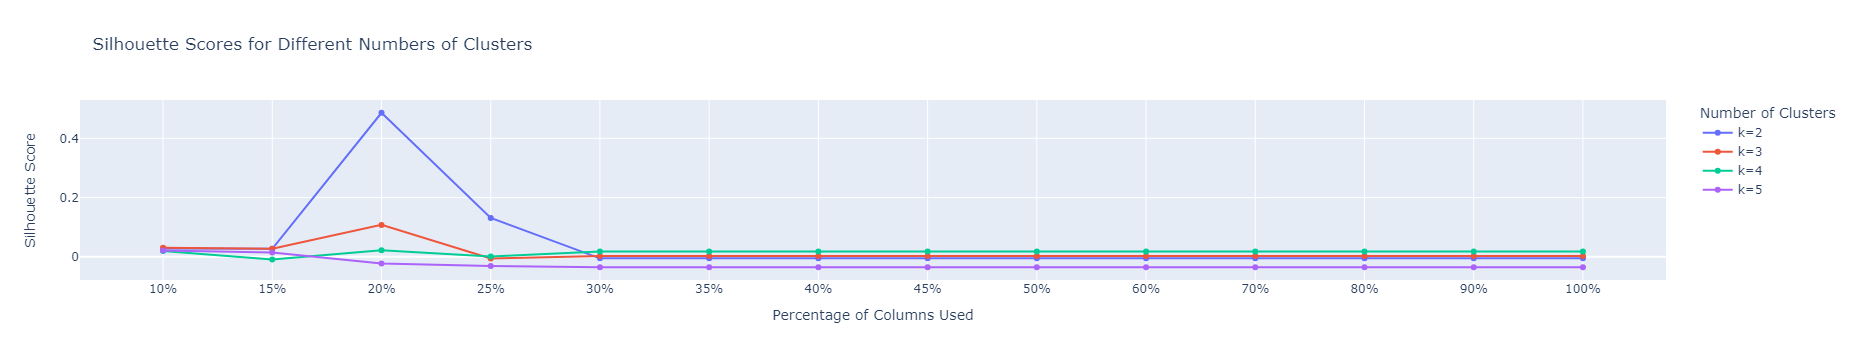

In [64]:
# List of percentages representing parts of the total columns to use for clustering
percentages = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Setup Plotly figure
fig = go.Figure()
# Process each percentage of columns
for k in range(2, 6):  # k varies from 2 to 5
    print("Code is running for Cluster", k)
    cluster_path = f"{output_path}/{k}_Clusters"
    if not os.path.exists(cluster_path):
        os.makedirs(cluster_path)
    silhouette_scores = []
    for p in percentages:
        top_columns_set = set()
        for key, mad_values in mad_dict.items():
            num_columns = int(len(mad_values[2]) * p)
            top_columns = [col[0] for col in mad_values[2][:num_columns]]
            #print(num_columns)
            #print(top_columns[0:2])
            top_columns_set.update(top_columns)
    
        print(len(top_columns_set))
        # Concatenate columns from each DataFrame based on top columns found across all DataFrames
        concatenated_df = pd.concat([df[list(top_columns_set & set(df.columns))] for df in dict_df.values()], axis=1)
        #display(concatenated_df)

        # Directory for the current percentage
        percentage_path = f"{cluster_path}/top_percentage_{int(p * 100)}"
        if not os.path.exists(percentage_path):
            os.makedirs(percentage_path)
        
        # Store top features for current percentage
        features_path = f"{percentage_path}/top_features.txt"
        with open(features_path, 'w') as file:
            for col in top_columns:
                file.write(col + '\n')
    
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(concatenated_df)
        #print("Scaled_data : ", scaled_data.shape[1])  # Output the number of features after scaling
        original_indices = concatenated_df.index  # Capture the original indices before scaling
    
    
        # This step reduces the number of dimensions in the data by transforming it to a new basisvwhere the variance retained is as specified (90% in this case). The goal is to reduce
        # complexity while keeping the most informative aspects of the data.  Apply PCA to reduce dimensionality while retaining 90% of the variance:
        # pca = PCA(n_components=0.90)  # Initialize PCA to retain 90% of the variance
        # data_reduced = pca.fit_transform(scaled_data)
        # print("Reduced to %d dimensions" % data_reduced.shape[1]) 
        
        # Compute silhouette score for the current number of clusters and percentage of columns
        score = kmeans_silhouette_score(scaled_data, k, percentage_path, original_indices, p)
        silhouette_scores.append(score)
    # Add the silhouette scores to the plot for the current number of clusters
    fig.add_trace(go.Scatter(
        x=[f"{int(p * 100)}%" for p in percentages],
        y=silhouette_scores,
        mode='lines+markers',
        name=f'k={k}'
    ))

# Update plot layout
fig.update_layout(
    title="Silhouette Scores for Different Numbers of Clusters",
    xaxis_title="Percentage of Columns Used",
    yaxis_title="Silhouette Score",
    legend_title="Number of Clusters"
)

# Show the plot
fig.show()

# Apply Hierarchical clustering

In [65]:
top_columns_set = set()
for key, mad_values in mad_dict.items():
    num_columns = int(len(mad_values[2]) * 0.20)
    top_columns = [col[0] for col in mad_values[2][:num_columns]]
    #print(num_columns)
    #print(top_columns[0:2])
    top_columns_set.update(top_columns)

print(len(top_columns_set))
# Concatenate columns from each DataFrame based on top columns found across all DataFrames
concatenated_df = pd.concat([df[list(top_columns_set & set(df.columns))] for df in dict_df.values()], axis=1)

1662


In [66]:
concatenated_df

,chr15_22672266_22672345_22672284_22672287_ATT_A,chr14_58231039_58231118_58231062_58231063_T_TC,chr11_33040089_33040168_33040109_33040110_C_CCTT,chr12_86011863_86011942_86011930_86011931_T_C,chrX_55487931_55488010_55487990_55487991_T_C,chr1_93183319_93183398_93183345_93183346_A_AT,chr4_57494513_57494592_57494523_57494531_ATTTTTTT_A,chr3_10035132_10035211_10035157_10035160_CTT_C,chr19_31195549_31195628_31195555_31195560_TTTTA_T,chr16_79106579_79106658_79106581_79106582_A_ATT,...,chr8_47977248_47977337_47977261_47977263_TC_T,chr2_20667099_20667188_20667102_20667103_T_G,chr2_238060921_238061010_238060950_238060951_A_G,chr8_22141863_22141952_22141881_22141886_CACTT_C,chr7_63248277_63248366_63248280_63248281_G_A,chr5_95732251_95732340_95732311_95732312_A_G,chr1_213988406_213988495_213988425_213988432_TAGAGAG_T,chrY_11314876_11314965_11314879_11314880_G_A,chr1_213988406_213988495_213988410_213988416_AGAGAG_A,chr12_8172492_8172581_8172494_8172495_C_CACA
Patient_Core_ID,,,,,,,,,,,,,,,,,,,,,
02eb77ff-2e07-4d56-9c32-d9fa415c7ce2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,-1,0,0,0,0,0,0
033db366-1af1-4bd9-8339-c54800b1de57,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,-1
03777cdf-6779-4d23-93af-5b74fb982d7b,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1
038750e2-9994-4420-bfa9-a3756683ddd1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,-1
03bdaae4-92e0-4229-9657-94510e2c3db7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f8b8e0df-4234-4839-b0ee-34a2c9ef4985,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1
f90f1702-d5f1-43f4-b167-2c440f941bf6,0,0,0,0,0,0,0,0,1,-1,...,0,0,0,0,0,0,0,0,0,-1
f9554b80-de24-4930-b651-7b2ae3b4ba8c,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1


In [67]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(concatenated_df)

In [68]:
scaled_data

array([[-0.18677184,  0.15161961,  0.0751646 , ..., -0.15161961,
        -0.10660036,  2.13600094],
       [-0.18677184,  0.15161961,  0.0751646 , ..., -0.15161961,
        -0.10660036, -0.46816459],
       [-0.18677184,  0.15161961,  0.0751646 , ..., -0.15161961,
        -0.10660036, -0.46816459],
       ...,
       [-0.18677184,  0.15161961,  0.0751646 , ..., -0.15161961,
        -0.10660036, -0.46816459],
       [-0.18677184,  0.15161961,  0.0751646 , ..., -0.15161961,
        -0.10660036, -0.46816459],
       [-0.18677184,  0.15161961,  0.0751646 , ..., -0.15161961,
        -0.10660036,  2.13600094]])

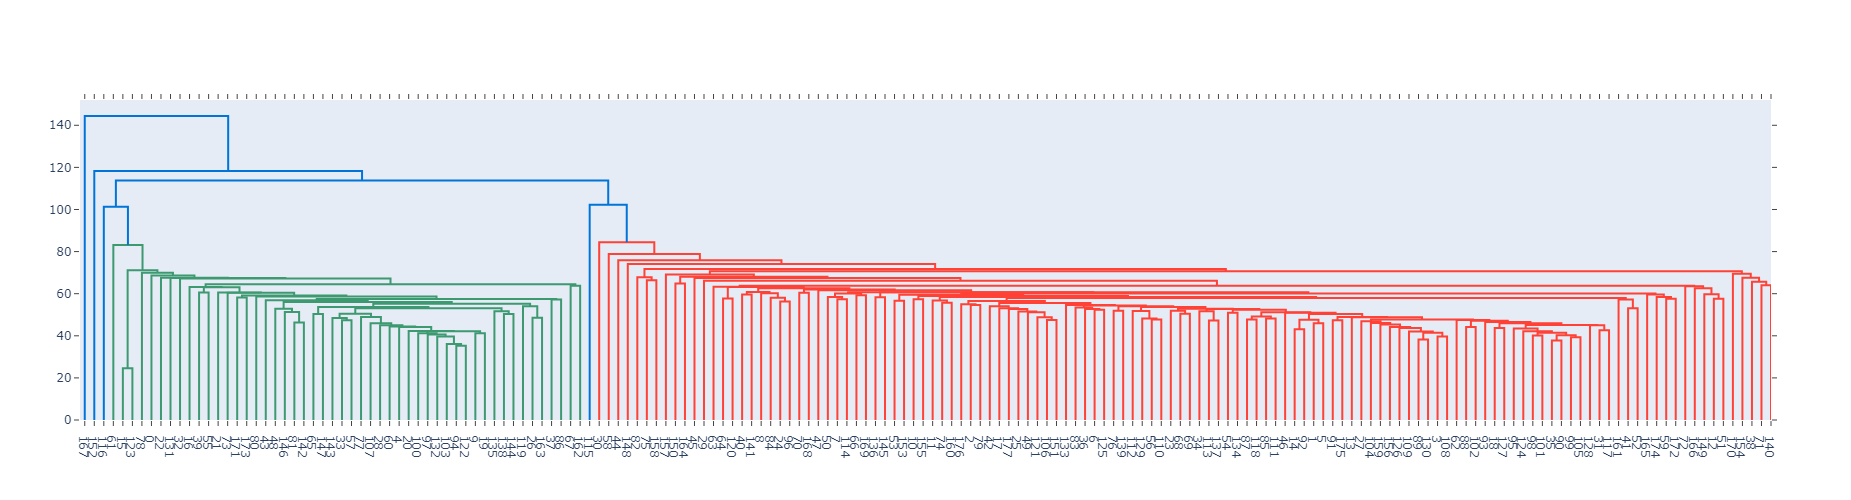

Silhouette Score for k=2: 0.4863957121310401
Silhouette Score for k=3: 0.39471351590494685
Silhouette Score for k=4: 0.02044794099488948
Silhouette Score for k=5: 0.022025494302483083


In [70]:
# Compute the linkage matrix using the Ward method
linked = linkage(scaled_data, method='ward')

# Plot the dendrogram
fig = ff.create_dendrogram(scaled_data, linkagefun=lambda x: linked, labels=None)
fig.update_layout(width=1800, height=500)
fig.show()

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = {}
for k in range(2, 6):
    # Use fcluster to flatten the dendrogram to 'k' clusters
    labels = fcluster(linked, k, criterion='maxclust')
    score = silhouette_score(scaled_data, labels)
    silhouette_scores[k] = score
    print(f'Silhouette Score for k={k}: {score}')

In [93]:
# Calculate silhouette scores and obtain labels for k=3
silhouette_scores = {}
labels_k3 = fcluster(linked, 6, criterion='maxclust')

# Map patient IDs to labels
patients_k3 = pd.Series(labels_k3, index=concatenated_df.index)

In [94]:
patients_k3_df = patients_k3.reset_index()
patients_k3_df.columns = ['manifest_patient_id', 'Cluster']

In [95]:
patients_k3_df[patients_k3_df['Cluster'] == 4]

,manifest_patient_id,Cluster
115,a58b5cd5-4625-4070-b672-4eb92cd7775c,4


In [96]:
clinical_df = pd.read_csv("/home/pdutta/Data/Cancer_wiseGDC/New_data/Brain/Clinical_biospecimen/clinical_mapping.tsv", sep= "\t")

In [97]:
clinical_df[clinical_df['manifest_patient_id']=="762bed3b-5d4a-41f6-9198-831f5c7a7348"]

,manifest_patient_id,submitter_id,patient,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type


In [98]:
# Merge the clinical data with the cluster labels DataFrame
merged_df = clinical_df.merge(patients_k3_df, on='manifest_patient_id', how='right')

In [99]:
merged_df

,manifest_patient_id,submitter_id,patient,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,...,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type,Cluster
0,02eb77ff-2e07-4d56-9c32-d9fa415c7ce2,C3N-04097-31,C3N-04097,a5e6fccb-a183-40d2-af7f-4c7aff3f9720,C3N-04097,CPTAC-3,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,1
1,033db366-1af1-4bd9-8339-c54800b1de57,C3N-04691-01,C3N-04691,65835e17-0795-4ee9-88ee-cf4961244905,C3N-04691,CPTAC-3,'--,'--,Unknown,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,3
2,03777cdf-6779-4d23-93af-5b74fb982d7b,C3N-01367-02,C3N-01367,4a21fc0b-d84d-4bc3-be3b-b2c0b14b97be,C3N-01367,CPTAC-3,'--,'--,Unknown,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,3
3,038750e2-9994-4420-bfa9-a3756683ddd1,C3N-01366-02,C3N-01366,a1da2f64-5a24-4e6b-abc1-e70aae23082c,C3N-01366,CPTAC-3,'--,'--,Surgical Complications,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,3
4,03bdaae4-92e0-4229-9657-94510e2c3db7,C3N-04312-02,C3N-04312,322a57c2-82ef-45cd-986d-759bb3916919,C3N-04312,CPTAC-3,'--,'--,Cancer Related,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,f8b8e0df-4234-4839-b0ee-34a2c9ef4985,C3N-03184-71,C3N-03184,f9a63d56-94cb-4f15-ac35-7c59a08f4104,C3N-03184,CPTAC-3,'--,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,1
174,f90f1702-d5f1-43f4-b167-2c440f941bf6,C3L-03740-01,C3L-03740,ab4e7812-4c98-4776-9eb6-e4994bd65d5d,C3L-03740,CPTAC-3,'--,'--,Cancer Related,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,3
175,f9554b80-de24-4930-b651-7b2ae3b4ba8c,C3N-00662-31,C3N-00662,1827eb4b-38f3-45b5-a833-156ba748c784,C3N-00662,CPTAC-3,'--,'--,Infection,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,3
176,fd27f3fc-6f0b-4794-8555-3111ad520493,C3L-03405-01,C3L-03405,ed9c82fb-ed4d-4254-a078-20a34cf82283,C3L-03405,CPTAC-3,'--,'--,"Cardiovascular Disorder, NOS",'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,3


In [100]:
merged_df['project_id'].value_counts(dropna=False)

project_id
CPTAC-3    178
Name: count, dtype: int64

In [101]:
merged_df['days_to_death'].value_counts(dropna=False)

days_to_death
'--    56
121     2
87      2
845     2
402     2
       ..
19      1
457     1
348     1
66      1
270     1
Name: count, Length: 115, dtype: int64

In [102]:
# Group by 'Cluster' and 'project_id', then count the number of patients in each group
cluster_project_distribution = merged_df.groupby(['Cluster', 'project_id']).size().unstack(fill_value=0)

In [103]:
cluster_project_distribution

project_id,CPTAC-3
Cluster,
1,50
2,1
3,124
4,1
5,1
6,1


In [104]:
merged_df.groupby(['Cluster', 'primary_diagnosis']).size().unstack(fill_value=0)

primary_diagnosis,Glioblastoma,"Oligodendroglioma, NOS","Oligodendroglioma, anaplastic",Unknown
Cluster,,,,
1,50,0,0,0
2,1,0,0,0
3,123,0,0,1
4,0,0,1,0
5,0,1,0,0
6,1,0,0,0


In [105]:
merged_df.groupby(['Cluster', 'site_of_resection_or_biopsy']).size().unstack(fill_value=0)

site_of_resection_or_biopsy,"Brain, NOS",Frontal lobe,Occipital lobe,Parietal lobe,Temporal lobe,Unknown
Cluster,,,,,,
1,18,11,2,1,18,0
2,1,0,0,0,0,0
3,10,38,9,22,44,1
4,0,1,0,0,0,0
5,0,1,0,0,0,0
6,0,0,0,1,0,0


In [106]:
merged_df.groupby(['Cluster', 'ethnicity']).size().unstack(fill_value=0)

ethnicity,hispanic or latino,not hispanic or latino,not reported
Cluster,,,
1,0,1,49
2,0,0,1
3,5,37,82
4,0,0,1
5,0,0,1
6,0,1,0


In [107]:
merged_df.groupby(['Cluster', 'race']).size().unstack(fill_value=0)

race,Unknown,asian,black or african american,not reported,other,white
Cluster,,,,,,
1,0,48,0,0,2,0
2,0,1,0,0,0,0
3,1,1,0,1,24,97
4,0,0,0,0,0,1
5,0,0,0,0,0,1
6,0,0,1,0,0,0


In [108]:
merged_df.groupby(['Cluster', 'vital_status']).size().unstack(fill_value=0)

vital_status,Alive,Dead
Cluster,,
1,17,33
2,0,1
3,35,89
4,1,0
5,0,1
6,0,1


In [109]:
merged_df.groupby(['Cluster', 'gender']).size().unstack(fill_value=0)

gender,female,male
Cluster,,
1,20,30
2,0,1
3,48,76
4,1,0
5,0,1
6,1,0


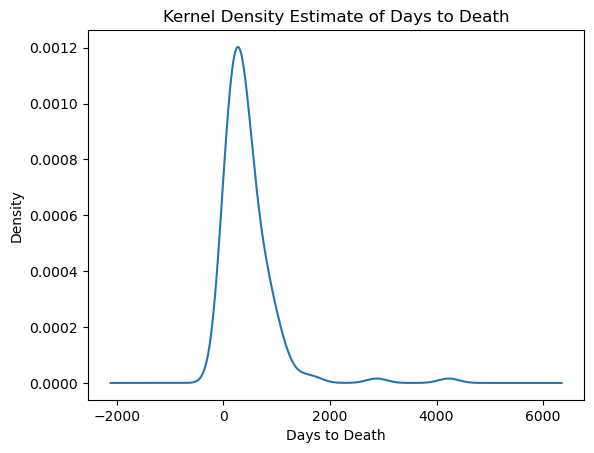

In [101]:
import matplotlib.pyplot as plt
# Ensure 'days_to_death' is in a suitable format (numeric) and handle any NaN values if necessary
merged_df['days_to_death'] = pd.to_numeric(merged_df['days_to_death'], errors='coerce')
merged_df['days_to_death'].dropna(inplace=True)

# Generate the KDE plot
merged_df['days_to_death'].plot.kde()
plt.title('Kernel Density Estimate of Days to Death')
plt.xlabel('Days to Death')
plt.ylabel('Density')
plt.show()

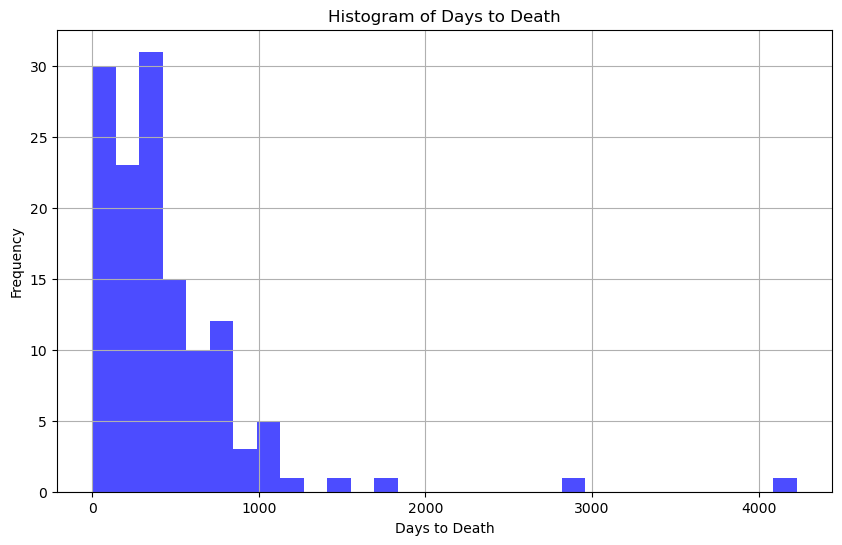

In [102]:
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame and it has a column 'days_to_death'
# Convert 'days_to_death' to numeric and handle any NaN values
merged_df['days_to_death'] = pd.to_numeric(merged_df['days_to_death'], errors='coerce')
merged_df['days_to_death'].dropna(inplace=True)

# Generate the histogram
plt.figure(figsize=(10, 6))
merged_df['days_to_death'].plot.hist(bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Days to Death')
plt.xlabel('Days to Death')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [110]:
import pandas as pd
import numpy as np

# Replace '--' with NaN (Not a Number)
merged_df['days_to_death'] = merged_df['days_to_death'].replace('--', np.nan)

# Convert 'days_to_death' to numeric, coercing errors will turn any non-convertible terms to NaN
merged_df['days_to_death'] = pd.to_numeric(merged_df['days_to_death'], errors='coerce')

# Check how many NaN values now
print("Count of NaN values in 'days_to_death':", merged_df['days_to_death'].isna().sum())
# Convert days to years
merged_df['years_to_death'] = merged_df['days_to_death'] / 365.25

# Define year bins
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, np.inf]  # 'np.inf' includes all values above the highest bin
labels = ['<1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-15 years', '15-20 years', '>20 years']

# Create a categorical column from years
merged_df['years_to_death_category'] = pd.cut(merged_df['years_to_death'], bins=bins, labels=labels, right=False)

# Display the distribution of the new categorical data
print(merged_df['years_to_death_category'].value_counts(dropna=False))

Count of NaN values in 'days_to_death': 56
years_to_death_category
<1 year        64
NaN            56
1-2 years      38
2-3 years      16
3-4 years       3
4-5 years       1
5-10 years      0
10-15 years     0
15-20 years     0
>20 years       0
Name: count, dtype: int64


In [111]:
merged_df.groupby(['Cluster', 'years_to_death_category']).size().unstack(fill_value=0)

/tmp/ipykernel_222727/3362698261.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



years_to_death_category,<1 year,1-2 years,2-3 years,3-4 years,4-5 years,5-10 years,10-15 years,15-20 years,>20 years
Cluster,,,,,,,,,
1,11,11,9,2,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,52,26,7,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0


In [112]:
# Define year bins including NaN
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, np.inf]
labels = ['<1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-15 years', '15-20 years', '>20 years']

# Create a categorical column from years, explicitly including NaN
merged_df['years_to_death_category'] = pd.cut(merged_df['years_to_death'], bins=bins, labels=labels, right=False)
merged_df['years_to_death_category'] = merged_df['years_to_death_category'].cat.add_categories(['Unknown']).fillna('Unknown')

# Now perform the groupby and unstack
grouped_data = merged_df.groupby(['Cluster', 'years_to_death_category']).size().unstack(fill_value=0)

# Show the grouped data
grouped_data

/tmp/ipykernel_222727/4132186707.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



years_to_death_category,<1 year,1-2 years,2-3 years,3-4 years,4-5 years,5-10 years,10-15 years,15-20 years,>20 years,Unknown
Cluster,,,,,,,,,,
1,11,11,9,2,0,0,0,0,0,17
2,0,1,0,0,0,0,0,0,0,0
3,52,26,7,1,1,0,0,0,0,37
4,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,0,0,0,0,0


In [40]:
merged_df

,manifest_patient_id,submitter_id,patient,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,...,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type,Cluster,years_to_death,years_to_death_category
1,033db366-1af1-4bd9-8339-c54800b1de57,C3N-04691-01,C3N-04691,65835e17-0795-4ee9-88ee-cf4961244905,C3N-04691,CPTAC-3,'--,'--,Unknown,'--,...,'--,'--,'--,'--,'--,'--,'--,2.0,0.703628,<1 year
2,03777cdf-6779-4d23-93af-5b74fb982d7b,C3N-01367-02,C3N-01367,4a21fc0b-d84d-4bc3-be3b-b2c0b14b97be,C3N-01367,CPTAC-3,'--,'--,Unknown,'--,...,'--,'--,'--,'--,'--,'--,'--,2.0,0.955510,<1 year
3,038750e2-9994-4420-bfa9-a3756683ddd1,C3N-01366-02,C3N-01366,a1da2f64-5a24-4e6b-abc1-e70aae23082c,C3N-01366,CPTAC-3,'--,'--,Surgical Complications,'--,...,'--,'--,'--,'--,'--,'--,'--,2.0,0.016427,<1 year
4,03ba06a3-5dc6-4dad-84ed-7fe3196d7402,TCGA-06-A7TK-10A,TCGA-06-A7TK,41685c5a-a548-483a-8a20-305ad8d61771,TCGA-06-A7TK,TCGA-GBM,64,'--,'--,'--,...,'--,'--,'--,'--,yes,'--,"Radiation Therapy, NOS",NaN,1.215606,1-2 years
5,03bdaae4-92e0-4229-9657-94510e2c3db7,C3N-04312-02,C3N-04312,322a57c2-82ef-45cd-986d-759bb3916919,C3N-04312,CPTAC-3,'--,'--,Cancer Related,'--,...,'--,'--,'--,'--,'--,'--,'--,1.0,1.207392,1-2 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,f701f323-9730-49f0-bbba-37a2f7566282,C3L-02900-31,C3L-02900,1e5eaf10-f6f1-4ab1-b0bf-fc3e0718b6bb,C3L-02900,CPTAC-3,'--,'--,Cancer Related,'--,...,'--,'--,'--,'--,'--,'--,'--,2.0,2.882957,2-3 years
210,f90f1702-d5f1-43f4-b167-2c440f941bf6,C3L-03740-01,C3L-03740,ab4e7812-4c98-4776-9eb6-e4994bd65d5d,C3L-03740,CPTAC-3,'--,'--,Cancer Related,'--,...,'--,'--,'--,'--,'--,'--,'--,2.0,0.235455,<1 year
211,f9554b80-de24-4930-b651-7b2ae3b4ba8c,C3N-00662-31,C3N-00662,1827eb4b-38f3-45b5-a833-156ba748c784,C3N-00662,CPTAC-3,'--,'--,Infection,'--,...,'--,'--,'--,'--,'--,'--,'--,2.0,0.317591,<1 year
212,fd27f3fc-6f0b-4794-8555-3111ad520493,C3L-03405-01,C3L-03405,ed9c82fb-ed4d-4254-a078-20a34cf82283,C3L-03405,CPTAC-3,'--,'--,"Cardiovascular Disorder, NOS",'--,...,'--,'--,'--,'--,'--,'--,'--,2.0,0.238193,<1 year
